In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import time
import os
from color_regions import ColorDatasetGenerator
import matplotlib.pyplot as plt
torch.backends.cudnn.benchmark = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
prev_time = 0
gamma = 0.99
stats = {}  # tracks ewma running average
def benchmark(point=None, profile=True, verbose=True, cuda=True): # not thread safe at all
    global prev_time
    if not profile:
        return
    if cuda:
        torch.cuda.synchronize()
    time_now = time.perf_counter()
    if point is not None:
        point = f"{sys._getframe().f_back.f_code.co_name}-{point}"
        time_taken = time_now - prev_time
        if point not in stats:
            stats[point] = time_taken
        stats[point] = stats[point]*gamma + time_taken*(1-gamma)
        if verbose:
            print(f"took {time_taken} to reach {point}, ewma={stats[point]}")
    prev_time = time_now

In [3]:
transform = transforms.Compose(
     [transforms.ToTensor()])#,
    #transforms.Normalize((0.5), (0.5))])

batch_size = 32  # seems to be the fastest batch size
train_indices = (0, 200_000) # size of training set
valid_indices = (250_000, 260_000)
test_indices = (260_000, 270_000)

def color_classifier(color):
    if color >= 150:  # valid colors (for now) for the circle is [100, 200], split in the middle
        return 1
    return 0

def set_loader_helper(indices):
    data_set = ColorDatasetGenerator(color_classifier=color_classifier,
                                    image_indices=indices,
                                    transform=transform,
                                    size=128,
                                    radius=(128//6, 128//3))
    loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=4, pin_memory=True)
    return data_set, loader
train_set, train_loader = set_loader_helper(train_indices)
valid_set, valid_loader = set_loader_helper(valid_indices)
test_set, test_loader = set_loader_helper(test_indices)

In [7]:
class ResNet(nn.Module):
    def __init__(self, conv_layers, num_classes, img_shape, path, groups=1):
        super().__init__()
        self.conv_layers1 = []  # entry into residual block 
        self.conv_layers2 = []  # https://arxiv.org/pdf/1512.03385.pdf Figure 3
        self.batch_norms1 = []
        self.batch_norms2 = []
        self.is_resid = []
        self.path = path
        self.num_classes = num_classes
        #self.shift = nn.Parameter(1)  # TODO: maybe add this (or just do an initial batchnorm)
        #self.scale = nn.Parameter(1)
        channels = img_shape[-1]
        img_size = img_shape[0]
        for l in conv_layers:  # (out_channels, kernel_size, stride) is each l
            if l[2] == 2: # stride
                pad_type = "valid"
                img_size = (img_size-l[1])//l[2] + 1 # https://arxiv.org/pdf/1603.07285.pdf
            else:
                pad_type = "same"
            if isinstance(l[0], float):
                l[0] = int(l[0])
                l[0] -= l[0] % groups # ensure divisble by groups
            self.is_resid.append(l[2] == 1 and channels == l[0])
            self.conv_layers1.append(nn.Conv2d(channels, l[0], l[1], stride=l[2], padding=pad_type, groups=groups))
            channels = l[0]
            self.final_num_logits = channels * img_size * img_size 
            self.batch_norms1.append(nn.BatchNorm2d(channels))
            self.batch_norms2.append(nn.BatchNorm2d(channels))
            self.conv_layers2.append(nn.Conv2d(channels, channels, l[1], padding=pad_type, groups=groups))
        self.conv_layers1 = nn.ModuleList(self.conv_layers1)
        self.conv_layers2 = nn.ModuleList(self.conv_layers1)
        self.batch_norms1 = nn.ModuleList(self.batch_norms1)
        self.batch_norms2 = nn.ModuleList(self.batch_norms2)

        self.fully_connected1 = nn.Linear(self.final_num_logits, 1000)
        self.fully_connected2 = nn.Linear(1000, num_classes)

    def forward(self, x, logits=False, profile=False):
        benchmark(profile=profile)
        network_iter = zip(self.conv_layers1, self.conv_layers2, self.batch_norms1, self.batch_norms2, self.is_resid)
        benchmark("iter create", profile=profile, verbose=False)
        for i, (conv1, conv2, batch_norm1, batch_norm2, is_resid) in enumerate(network_iter):
            x_conv1 = F.relu(batch_norm1(conv1(x)))
            benchmark(f"conv_bn_relu {i}+1", profile=profile, verbose=False)
            x_conv2 = F.relu(batch_norm2(conv2(x)))
            benchmark(f"conv_bn_relu {i}+2", profile=profile, verbose=False)
            if is_resid:
                x = x + x_conv2  # residual block
            else:
                x = x_conv2  # dimension increasing block
            benchmark(f"is_resid {i}", profile=profile, verbose=False)
        x = torch.flatten(x, 1)
        benchmark(f"flatten", profile=profile, verbose=False)
        x = F.relu(self.fully_connected1(x))
        benchmark(f"relu fc 1", profile=profile, verbose=False)
        x = self.fully_connected2(x)
        benchmark(f"relu fc 2", profile=profile, verbose=False)
        if self.num_classes == 1 and not logits:  # always allow returning logits
            x = torch.sigmoid(x)
        benchmark(f"final", profile=profile, verbose=False)
        return x    

    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if optim is not None:
            save_dict = {}
            save_dict["model"] = self.state_dict()
            save_dict["optim"] = optim.state_dict()
        else:
            save_dict = self.state_dict()
        torch.save(save_dict, path)
    
    def load_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if not os.path.exists(path):
            return
        load_dict = torch.load(path)
        if "model" in load_dict:
            if optim is not None:
                optim.load_state_dict(load_dict["optim"]) 
            self.load_state_dict(load_dict["model"])
        else:
            self.load_state_dict(load_dict)

In [5]:
def correct(pred_logits, labels):
    if labels.shape[1] != 1:
        pred_probabilities = F.softmax(pred_logits, dim=1)
        classifications = torch.argmax(pred_probabilities, dim=1)
        labels_argmax = torch.argmax(labels, dim=1)
    else:
        classifications = pred_logits.int()
        labels_argmax = labels
    correct = (labels_argmax == classifications)
    return correct

def train(net, optimizer, loss, epochs):
    va_losses = []
    tr_losses = []
    va_accuracies = []
    for epoch in range(epochs):
        net.save_model_state_dict(optim=optimizer)
        epoch_tr_loss = 0.0
        net.train()
        for i, sample in tqdm(enumerate(train_loader)):
#             if i == 0:
#                 overall_start = time.perf_counter()
#                 overall_to_time = 0
#                 overall_fwd_time = 0
#                 overall_net_time = 0
#                 overall_gen_time = 0
#             else:
#                 overall_gen_time += time.perf_counter()-gen_time
#             torch.cuda.synchronize()
#             to_time = time.perf_counter()
            imgs = sample["image"].to(device, non_blocking=False).float()
            labels = sample["label"].to(device).float()
#             torch.cuda.synchronize()
#             overall_to_time += time.perf_counter() - to_time
            optimizer.zero_grad()
#             torch.cuda.synchronize()
#             fwd_time = time.perf_counter()
            outputs = net(imgs)
#             torch.cuda.synchronize()
#             overall_fwd_time += time.perf_counter() - fwd_time
            batch_loss = loss(outputs, labels)
            epoch_tr_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
#             torch.cuda.synchronize()
#             overall_net_time += time.perf_counter() - fwd_time
#             torch.cuda.synchronize()
#             gen_time = time.perf_counter()
#             if i % 50 == 49:
#                 print("overall_time", time.perf_counter() - overall_start)
#                 print("overall_net_time", overall_net_time)
#                 print("overall_fwd_time", overall_fwd_time)
#                 print("overall_to_time", overall_to_time)
#                 print("overall_gen_time", overall_gen_time)
#                 overall_to_time = 0
#                 overall_fwd_time = 0
#                 overall_net_time = 0
#                 overall_gen_time = 0
#                 overall_start = time.perf_counter()   
        epoch_va_loss = 0.0
        epoch_va_correct = 0
        net.eval()
        with torch.no_grad():
            for i, sample in enumerate(valid_loader):
                imgs = sample["image"].to(device).float()
                labels = sample["label"].to(device).float()
                outputs = net(imgs)
                epoch_va_loss += loss(outputs, labels).item()
                epoch_va_correct += correct(outputs, labels).sum().item()
        epoch_va_accuracy = epoch_va_correct/(valid_indices[1] - valid_indices[0])
        print(f'Epoch {epoch + 1}: va_loss: {epoch_va_loss}, va_accuracy: {epoch_va_accuracy}, tr_loss: {epoch_tr_loss}')
        va_losses.append(epoch_va_loss)
        tr_losses.append(epoch_tr_loss)
        va_accuracies.append(epoch_va_accuracy)
    return va_losses, va_accuracies, tr_losses

In [8]:
res_net = ResNet([[64, 7, 1],  # num_channels (input and output), kernel_size, stride
                  [64, 3, 1],
                  [128, 3, 2],
                  [128, 3, 1],
                  [128, 3, 2],
                  [128, 3, 1],
                  [256, 3, 2],
                  [256, 3, 1],
                  [256, 3, 1],
                  [256, 3, 2],
                  [512, 3, 1],
                  [512, 3, 2],
                  [512, 3, 1]], 1, [128, 128, 1], "greyscale_small_no_norm.dict").to(device)
loss_func = nn.BCELoss()
optim = torch.optim.Adam(res_net.parameters())
print(res_net.num_params())
res_net.load_model_state_dict(optim=optim)

13144721


In [52]:
results = train(res_net, optim, loss_func, 200)

6250it [10:34,  9.85it/s]


Epoch 1: va_loss: 19.773438220610842, va_accuracy: 0.5732, tr_loss: 607.8701411306392


6250it [10:34,  9.85it/s]


Epoch 2: va_loss: 19.10238972713887, va_accuracy: 0.6188, tr_loss: 334.40583115141726


6250it [10:34,  9.85it/s]


Epoch 3: va_loss: 32.06361270743946, va_accuracy: 0.5398, tr_loss: 273.3968760302181


6250it [10:34,  9.86it/s]


Epoch 4: va_loss: 6.251392223140101, va_accuracy: 0.7032, tr_loss: 217.6242285805936


6250it [10:34,  9.85it/s]


Epoch 5: va_loss: 9.047536876038976, va_accuracy: 0.7987, tr_loss: 179.29711038275883


6250it [10:34,  9.85it/s]


Epoch 6: va_loss: 31.868070280858973, va_accuracy: 0.7087, tr_loss: 164.92140804808585


6250it [10:34,  9.85it/s]


Epoch 7: va_loss: 3.94932254410271, va_accuracy: 0.8336, tr_loss: 152.37319571015072


6250it [10:34,  9.86it/s]


Epoch 8: va_loss: 4.040989583128475, va_accuracy: 0.8167, tr_loss: 142.39760530091212


6250it [10:34,  9.85it/s]


Epoch 9: va_loss: 4.656233056187574, va_accuracy: 0.8561, tr_loss: 133.14217868281557


6250it [10:34,  9.85it/s]


Epoch 10: va_loss: 5.816616924491823, va_accuracy: 0.9309, tr_loss: 136.0893304173616


6250it [10:34,  9.85it/s]


Epoch 11: va_loss: 7.49159262006151, va_accuracy: 0.8995, tr_loss: 128.23657603369887


6250it [10:34,  9.85it/s]


Epoch 12: va_loss: 6.29441291723791, va_accuracy: 0.9303, tr_loss: 180.99699598844222


6250it [10:34,  9.84it/s]


Epoch 13: va_loss: 6.754575083895421, va_accuracy: 0.9059, tr_loss: 117.57750456131738


6250it [10:35,  9.83it/s]


Epoch 14: va_loss: 3.575929839778492, va_accuracy: 0.9361, tr_loss: 118.99182607972934


6250it [10:35,  9.84it/s]


Epoch 15: va_loss: 3.201466126454186, va_accuracy: 0.9197, tr_loss: 111.43423215692782


6250it [10:34,  9.84it/s]


Epoch 16: va_loss: 2.9291746104451515, va_accuracy: 0.9355, tr_loss: 166.7733693048476


6250it [10:34,  9.85it/s]


Epoch 17: va_loss: 16.171181458724277, va_accuracy: 0.7997, tr_loss: 104.63117980123299


6250it [10:34,  9.85it/s]


Epoch 18: va_loss: 2.3142875543415333, va_accuracy: 0.9414, tr_loss: 106.07507976626754


6250it [10:34,  9.85it/s]


Epoch 19: va_loss: 2.0373809616951584, va_accuracy: 0.9246, tr_loss: 95.09985119424326


6250it [10:34,  9.85it/s]


Epoch 20: va_loss: 1.8834471946832374, va_accuracy: 0.9398, tr_loss: 91.18721096761698


6250it [10:34,  9.84it/s]


Epoch 21: va_loss: 1.3457960957654618, va_accuracy: 0.9301, tr_loss: 96.51624374484761


6250it [10:35,  9.83it/s]


Epoch 22: va_loss: 1.454218523924149, va_accuracy: 0.9377, tr_loss: 73.08498867127757


6250it [10:35,  9.83it/s]


Epoch 23: va_loss: 2.088089142617853, va_accuracy: 0.9422, tr_loss: 76.95169309733286


6250it [10:34,  9.85it/s]


Epoch 24: va_loss: 1.018854571354174, va_accuracy: 0.9573, tr_loss: 67.09240683814818


6250it [10:35,  9.84it/s]


Epoch 25: va_loss: 1.32419104603313, va_accuracy: 0.9474, tr_loss: 78.77640874813801


6250it [10:35,  9.84it/s]


Epoch 26: va_loss: 3.1268694669750765, va_accuracy: 0.9344, tr_loss: 58.894636514711806


6250it [10:35,  9.84it/s]


Epoch 27: va_loss: 1.3533751981559452, va_accuracy: 0.9408, tr_loss: 55.8266538252613


6250it [10:35,  9.84it/s]


Epoch 28: va_loss: 2.3017992498088446, va_accuracy: 0.9375, tr_loss: 55.95375321656015


6250it [10:35,  9.84it/s]


Epoch 29: va_loss: 1.0445053212906616, va_accuracy: 0.9385, tr_loss: 50.74610767037445


6250it [10:35,  9.84it/s]


Epoch 30: va_loss: 0.2805866802222772, va_accuracy: 0.9369, tr_loss: 57.44858289586746


6250it [10:34,  9.85it/s]


Epoch 31: va_loss: 0.5061486848234131, va_accuracy: 0.9475, tr_loss: 40.40457276730314


6250it [10:35,  9.84it/s]


Epoch 32: va_loss: 1.433787971289981, va_accuracy: 0.9444, tr_loss: 40.494189704053426


6250it [10:34,  9.84it/s]


Epoch 33: va_loss: 0.4415876854264993, va_accuracy: 0.9596, tr_loss: 40.173439754547374


6250it [10:35,  9.84it/s]


Epoch 34: va_loss: 0.2563856969388252, va_accuracy: 0.9574, tr_loss: 41.653773119150685


6250it [10:35,  9.84it/s]


Epoch 35: va_loss: 0.31376403899101746, va_accuracy: 0.957, tr_loss: 32.399936138844666


6250it [10:34,  9.84it/s]


Epoch 36: va_loss: 0.9065093521847825, va_accuracy: 0.9534, tr_loss: 33.21982651578467


6250it [10:35,  9.84it/s]


Epoch 37: va_loss: 0.18686243267261426, va_accuracy: 0.9348, tr_loss: 32.22713146144162


6250it [10:35,  9.84it/s]


Epoch 38: va_loss: 0.6201196509741869, va_accuracy: 0.9436, tr_loss: 31.43975345220663


6250it [10:35,  9.84it/s]


Epoch 39: va_loss: 0.47985407025218896, va_accuracy: 0.9235, tr_loss: 30.35178125586303


6250it [10:35,  9.84it/s]


Epoch 40: va_loss: 0.09263674690183166, va_accuracy: 0.9551, tr_loss: 36.012610842138244


6250it [10:34,  9.84it/s]


Epoch 41: va_loss: 0.11284889322851965, va_accuracy: 0.9522, tr_loss: 32.40616226522651


6250it [10:35,  9.84it/s]


Epoch 42: va_loss: 0.16783010461539183, va_accuracy: 0.9542, tr_loss: 31.061795353949687


6250it [10:35,  9.84it/s]


Epoch 43: va_loss: 0.09251690385458211, va_accuracy: 0.9448, tr_loss: 25.528227615493915


6250it [10:35,  9.84it/s]


Epoch 44: va_loss: 0.03217671126151833, va_accuracy: 0.964, tr_loss: 29.659963453498463


2206it [03:44,  9.84it/s]


KeyboardInterrupt: 

In [53]:
@torch.no_grad()
def rate_distribution(net, loader, dataset, buckets=100):
    total = np.zeros((buckets))
    num_correct = np.zeros((buckets))
    num_possible_colors = dataset.color_range[1] - dataset.color_range[0]
    for sample in tqdm(loader):
        imgs = sample["image"].to(device).float()
        labels = sample["label"].to(device).float()
        actual_colors = sample["color"]
        color_indices = (buckets * (actual_colors - dataset.color_range[0]) / num_possible_colors).int().numpy()
        outputs = net(imgs)
        correct_preds = correct(outputs, labels).cpu().numpy()
        for i, color_idx in enumerate(color_indices):
            total[color_idx] += 1  
            num_correct[color_idx] += correct_preds[i]
    return num_correct, total
_num_correct, _total = rate_distribution(res_net, valid_loader, valid_set)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 19.94it/s]


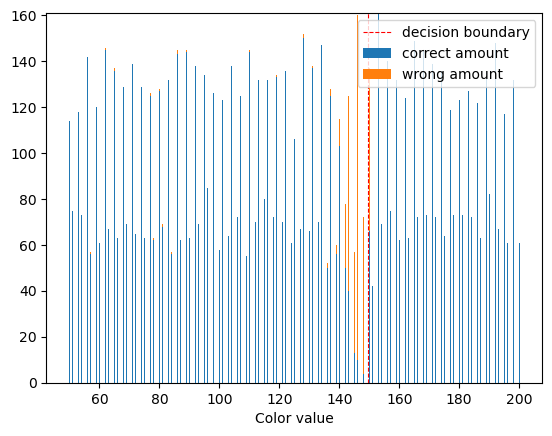

In [54]:
def make_graph(num_correct, total, dataset, critical_values=[150-0.5], buckets=100):
    num_wrong = total - num_correct
    width = 0.4
    labels = [int(x) for i, x in enumerate(np.linspace(*dataset.color_range, buckets))]
    plt.bar(labels, num_correct, width, label="correct amount")
    plt.bar(labels, num_wrong, width, bottom=num_correct, label="wrong amount")
    plt.vlines(critical_values, 0, np.max(total), linewidth=0.8,
               colors="r", label="decision boundary",
               linestyles="dashed")
    plt.legend()
    plt.xlabel("Color value")
    plt.show()
make_graph(_num_correct, _total, valid_set)  # => regions of ~40+ pixel values learnable?

In [15]:
test_index = 123_456
counterfactual_color_values = np.linspace(0, 255, 255)
responses = []
for color in counterfactual_color_values:
    np.random.seed(test_index)
    generated_img, _, __ = valid_set.generate_one(set_color=color)
    generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
    generated_img = torch.tensor(generated_img).to(device).float()
    response = res_net(torch.tensor(generated_img).to(device).float(), logits=True).item()
    responses.append(response)

/tmp/ipykernel_1284496/3885711597.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  response = res_net(torch.tensor(generated_img).to(device).float(), logits=True).item()


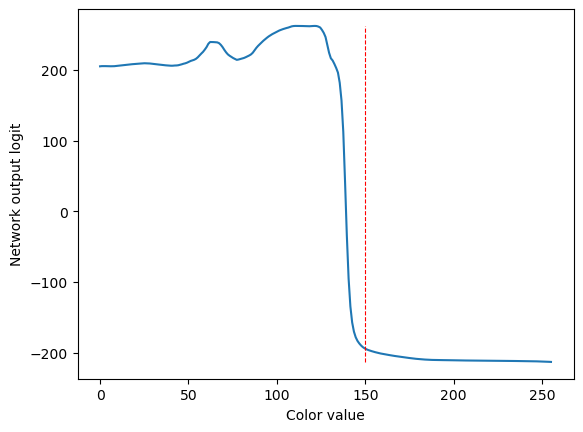

In [17]:
plt.plot(counterfactual_color_values, responses)  # literally backwards???????
plt.xlabel("Color value")
plt.ylabel("Network output logit")
plt.vlines([150], min(responses), max(responses), linewidth=0.8,
           colors="r", label="decision boundary",
           linestyles="dashed")

In [75]:
@torch.no_grad()
def finite_differences(model, dataset, target_class, stacked_img, locations, channel, values_prior):
    num_iters = 20 # sample 20 values evenly spaced
    cuda_stacked_img = torch.tensor(stacked_img).to(device)
    if dataset.num_classes == 2:
        class_multiplier = 1 if target_class == 1 else -1 
        baseline_activations = class_multiplier*model(cuda_stacked_img, logits=True)
    else:
        baseline_activations = model(cuda_stacked_img)[:, target_class]
    largest_slope = np.zeros(stacked_img.shape[0])  # directional finite difference?
    slices = np.index_exp[np.arange(stacked_img.shape[0]), channel, locations[:, 0], locations[:, 1]]
    if values_prior is None:
        values_prior = np.linspace(5, 250, stacked_img.shape[0]) # uniform distribution assumption
    for i in range(num_iters):
        shift_img = stacked_img.copy()
        shift_img[slices] = values_prior[i]+0.01  # add tiny offset to "guarantee" non-zero shift
        
        actual_diffs = shift_img[slices] - stacked_img[slices]  # due to clipping, need to recalculate
        # img_norm = dataset.transform(img).to(device).float() manually do this because transforms dont work on batched imputs
        #img_norm = (torch.tensor(img/255.)-0.5) / 0.5 
        img_norm = torch.tensor(shift_img).to(device) # best is no normalization anyway
        if dataset.num_classes == 2:
            activations = class_multiplier*model(img_norm, logits=True)
        else:
            activations = model(img_norm)[:, target_class]
        activation_diff = (activations - baseline_activations).cpu().numpy().squeeze()
        finite_difference = np.clip(activation_diff/actual_diffs, -30, 30) # take absolute slope
        largest_slope = np.where(abs(finite_difference) > abs(largest_slope), finite_difference, largest_slope)
    return largest_slope
        

def finite_differences_map(model, dataset, target_class, img, values_prior=None):
    # generate a saliency map using finite differences method (iterate over colors)
    model.eval()
    batch_size = 32  # check batch_size num pixel positions in parallel
    im_size = dataset.size
    #img = img.astype(np.float32)/255. # normalization handled later
    values_x = np.repeat(np.arange(im_size), im_size)
    values_y = np.tile(np.arange(im_size), im_size)
    indices = np.stack((values_x, values_y), axis=1)
    stacked_img = np.repeat(np.expand_dims(img, 0), batch_size, axis=0)
    stacked_img = np.transpose(stacked_img, (0, 3, 1, 2)).astype(np.float32) # NCHW format
    img_heat_map = np.zeros_like(img)
    for channel in range(dataset.channels):
        for k in tqdm(range(0, im_size*im_size, batch_size)):
            actual_batch_size = min(batch_size, im_size*im_size-k+batch_size)
            locations = indices[k:k+batch_size]
            largest_slopes = finite_differences(model, dataset, target_class, stacked_img, locations, channel, values_prior)
            img_heat_map[locations[:,0], locations[:,1], channel] = largest_slopes
    return img_heat_map#.sum(axis=2)  # linear approximation aggregation?
np.random.seed(500_001)
explain_img, _, __ = valid_set.generate_one()
heat_map = finite_differences_map(res_net, valid_set, 0, explain_img)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [08:16<00:00,  1.03it/s]


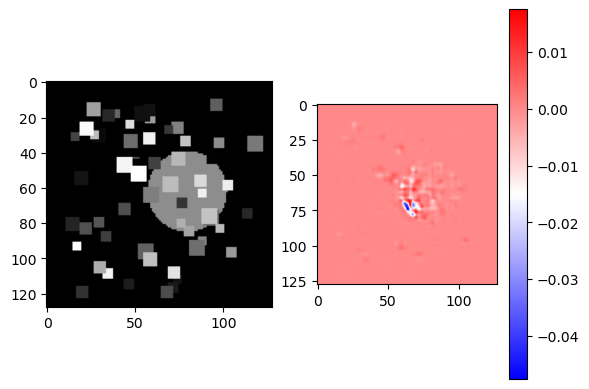

In [78]:
plt.subplot(1, 2, 1)
plt.imshow(explain_img, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(heat_map, cmap="bwr", interpolation="bilinear")
plt.colorbar()

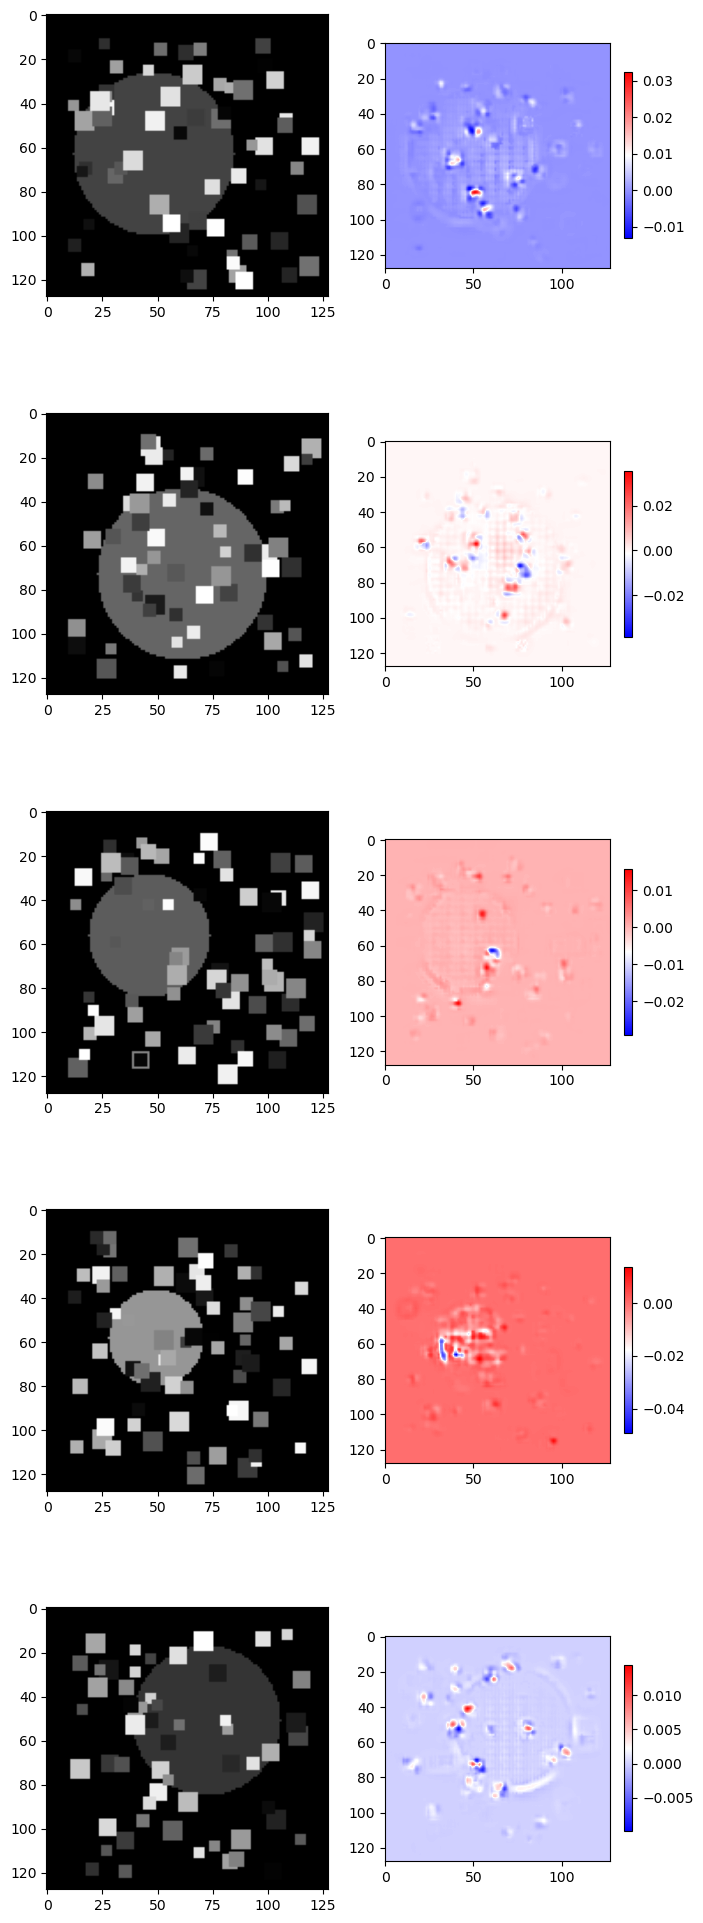

In [83]:
image_ids = [20_000, 25_000, 30_000, 600_000, 600_001]
#heat_maps = []
plt.figure(figsize=(8, 5*len(image_ids)))
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, __ = valid_set.generate_one()
    class_mult = 1 if target_i == 1 else -1  # shouldnt have to do this anymore, remove
    heat_map_i = heat_maps[i]*class_mult
    #heat_map_i = finite_differences_map(res_net, valid_set, target_i, explain_img_i)
    #heat_maps.append(heat_map_i)
    plt.subplot(len(image_ids), 2, 2*i+1)
    plt.imshow(explain_img_i, cmap="gray")
    plt.subplot(len(image_ids), 2, 2*i+2)
    plt.imshow(heat_map_i, cmap="bwr", interpolation="bilinear")
    plt.colorbar(shrink=0.5)
plt.show()

What if we run the same experiment, but cheat with a prior on pixel values that we know *should* have high finite differences, namely values closest to the decision boundary?

In [22]:
unfair_prior = np.array([130, 140, 160, 170])  #  close to the critical value of 150
unfair_heat_maps = []
plt.figure(figsize=(12, 5*len(image_ids)))
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, __ = valid_set.generate_one()
    unfair_map_i = finite_differences_map(res_net, valid_set, target_i, explain_img_i, values_prior=unfair_prior)
    unfair_heat_maps.append(unfair_map_i)
    plt.subplot(len(image_ids), 3, 3*i+1)
    plt.imshow(explain_img_i, cmap="gray")
    plt.subplot(len(image_ids), 3, 3*i+2)
    plt.imshow(unfair_map_i, cmap="bwr", interpolation="bilinear")
    plt.colorbar(shrink=0.5)
    plt.subplot(len(image_ids), 3, 3*i+3)
    plt.imshow(heat_maps[i], cmap="bwr", interpolation="bilinear") # technically need the class_mult here, since these heat_maps[] were computed without that
    plt.colorbar(shrink=0.5)
plt.show()

NameError: name 'image_ids' is not defined

# Model Optimization Stuff

In [84]:
res_net.save_model_state_dict(optim=optim)

In [20]:
for _ in range(1000):
    res_net.forward(generated_img, profile=True)

In [21]:
total = sum(stats.values())  # --> gave 3x speed! (Fast and Accurate Model scaling?)
for k,v in stats.items():    # --> the 3x speedup caused underfitting though, so switched to 2x
    print(k,(100.*v/total))


forward-iter create 0.20726188370102722
forward-conv_bn_relu 0+1 2.7006421528858877
forward-conv_bn_relu 0+2 2.46820488389047
forward-is_resid 0 0.140192307181084
forward-conv_bn_relu 1+1 7.7374812862698406
forward-conv_bn_relu 1+2 7.666144324683222
forward-is_resid 1 0.800288543219722
forward-conv_bn_relu 2+1 3.1146057552987405
forward-conv_bn_relu 2+2 3.0776592523305655
forward-is_resid 2 0.14662447736729572
forward-conv_bn_relu 3+1 4.7860635998511984
forward-conv_bn_relu 3+2 4.776948196896868
forward-is_resid 3 0.4458012170567157
forward-conv_bn_relu 4+1 2.8268881864514457
forward-conv_bn_relu 4+2 2.754490443847031
forward-is_resid 4 0.14374684725033482
forward-conv_bn_relu 5+1 2.7202806749200072
forward-conv_bn_relu 5+2 2.6010979085685193
forward-is_resid 5 0.34566739955608067
forward-conv_bn_relu 6+1 2.6879107607363375
forward-conv_bn_relu 6+2 2.5640864766509917
forward-is_resid 6 0.1396393620568139
forward-conv_bn_relu 7+1 2.8555258848705014
forward-conv_bn_relu 7+2 2.83175361368